In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from matplotlib.lines import Line2D

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1sps9uww because the default path (/home/sarslan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
FIG_SIZE = (8,5)
plt.rcParams["figure.figsize"] = FIG_SIZE
FONT_SIZE = 16
LINE_STYLE = (0,(4,4))
LINE_WIDTH = 3.5
SAVE_FIG = False

In [3]:
EXP_ID = '230511-1257'
data_folder = '../data/' + EXP_ID + '/'
exp_filename = data_folder + 'energy.log'

if (SAVE_FIG):
    out_dir = '../outputs/' + EXP_ID + '/'
    if (not os.path.exists(out_dir)):
        os.mkdir(out_dir)

In [4]:
def read_energy_log(exp_filename):
    data = []
    with open(exp_filename,'r') as f:
        for line in f:
            exp = {}
            for item in line.split():
                key, val = item.split('=')
                if key in ['energy_uJ']:
                    val = float(val)
                elif key in ['mtu']:
                    val = int(val)
                exp[key] = val
            if val > 0:
                data.append(exp)

    df = pd.DataFrame(data)
    return df

In [5]:
def read_iperf_log(df, data_folder):
    total_cpu_util_percent = []
    user_cpu_util_percent = []
    system_cpu_util_percent = []
    time_sec = []
    sent_bytes = []
    bps = []
    rtx_pkts = []
    min_rtts = []
    mean_rtts = []
    max_rtts = []
    max_cwnds = []
    for _, row in df.iterrows():
        json_filename = data_folder + row['cc'] + '_' + str(row['mtu']) + '_' + row['cnt'] + '.json'
        with open(json_filename, 'r') as f:
            iperf_data = json.load(f)

            total_cpu_util_percent.append(iperf_data['end']['cpu_utilization_percent']['host_total'])
            user_cpu_util_percent.append(iperf_data['end']['cpu_utilization_percent']['host_user'])
            system_cpu_util_percent.append(iperf_data['end']['cpu_utilization_percent']['host_system'])

            if row['cc'] == 'udp':
                sum_str = 'sum' 
                rtx = 0
                min_rtt = np.nan
                mean_rtt = np.nan
                max_rtt = np.nan
                max_cwnd = np.nan
            else: 
                sum_str = 'sum_sent'
                rtx = iperf_data['end'][sum_str]['retransmits']
                min_rtt = iperf_data['end']['streams'][0]['sender']['min_rtt'] * 1e-3
                mean_rtt = iperf_data['end']['streams'][0]['sender']['mean_rtt'] * 1e-3
                max_rtt = iperf_data['end']['streams'][0]['sender']['max_rtt'] * 1e-3
                max_cwnd = iperf_data['end']['streams'][0]['sender']['max_snd_cwnd']

            time_sec.append(iperf_data['end'][sum_str]['seconds'])
            sent_bytes.append(iperf_data['end'][sum_str]['bytes'])
            bps.append(iperf_data['end'][sum_str]['bits_per_second'])
            rtx_pkts.append(rtx)
            min_rtts.append(min_rtt)
            mean_rtts.append(mean_rtt)
            max_rtts.append(max_rtt)
            max_cwnds.append(max_cwnd)

    df = df.assign(total_cpu_util_percent = total_cpu_util_percent, 
                   user_cpu_util_percent = user_cpu_util_percent, 
                   system_cpu_util_percent = system_cpu_util_percent, 
                   time_sec = time_sec, sent_bytes = sent_bytes, bps = bps, 
                   rtx_pkts = rtx_pkts, min_rtt = min_rtts, 
                   mean_rtt = mean_rtts, max_rtt = max_rtts, 
                   max_cwnd = max_cwnds)
    return df

# Reading the Experiment Data

In [6]:
exp_df = read_energy_log(exp_filename)
exp_df['energy_kJ'] = exp_df['energy_uJ'] * 10e-9
exp_df = read_iperf_log(exp_df, data_folder)
exp_df

,cc,mtu,cnt,energy_uJ,energy_kJ,total_cpu_util_percent,user_cpu_util_percent,system_cpu_util_percent,time_sec,sent_bytes,bps,rtx_pkts,min_rtt,mean_rtt,max_rtt,max_cwnd
0,udp,1500,1,5.301391e+09,53.013913,80.426079,19.336575,61.089503,94.128428,53687092008,4.562893e+09,0,NaN,NaN,NaN,NaN
1,udp,1500,2,5.232915e+09,52.329153,77.979218,18.978622,59.000595,95.599893,53687092008,4.492655e+09,0,NaN,NaN,NaN,NaN
2,udp,1500,3,4.504067e+09,45.040673,88.179867,21.257274,66.922592,81.386496,53687092008,5.277257e+09,0,NaN,NaN,NaN,NaN
3,udp,1500,4,4.821466e+09,48.214664,85.120456,20.341678,64.778774,86.386276,53687092008,4.971827e+09,0,NaN,NaN,NaN,NaN
4,udp,1500,5,5.069874e+09,50.698740,86.256166,19.572797,66.683368,90.743231,53687092008,4.733106e+09,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,highspeed,9000,16,1.498434e+09,14.984337,30.478618,1.312862,29.165758,43.397293,53687222272,9.896879e+09,4222,1.330,1.330,1.330,1637484.0
869,highspeed,9000,17,1.503330e+09,15.033300,30.935328,1.294604,29.640726,43.390395,53687091200,9.898429e+09,3450,1.416,1.416,1.416,1780652.0
870,highspeed,9000,18,1.481979e+09,14.819789,27.055601,1.243711,25.811888,43.391734,53687091200,9.898123e+09,3654,1.344,1.344,1.344,1073760.0
871,highspeed,9000,19,1.482374e+09,14.823743,26.700359,1.091406,25.608951,43.394238,53687091200,9.897552e+09,3669,1.166,1.166,1.166,1476420.0


# Overall Energy Consumption vs CCA and MTU

In [7]:
print('========== Average Energy Consumption (kJ) ==========')
print(exp_df.groupby(['cc', 'mtu'])['energy_kJ'].mean().unstack().sort_values([1500]))
print('\n====== St. Deviation in Energy Consumption (kJ) =====')
print(exp_df.groupby(['cc', 'mtu'])['energy_kJ'].std().unstack().sort_values([1500]))

========== Average Energy Consumption (kJ) ==========
mtu             1500       3000       6000       9000
cc                                                   
bbr        17.533398  16.061361  15.441354  15.178878
westwood   18.111714  16.074099  15.292918  15.102288
highspeed  18.127050  15.962873  15.316245  15.130564
scalable   18.245621  15.941827  15.310556  15.112507
reno       18.392465  16.136457  15.327474  15.040264
vegas      18.572103  16.014153  15.262459  14.991724
dctcp      18.752241  16.067216  15.308678  15.144951
cubic      18.759629  15.984656  15.346745  15.129304
none       20.433022  18.223246  17.277478  16.658225
bbr2       24.553868  20.480618  17.474273  16.720950
udp        48.991093  34.610938  20.215456  23.410399

====== St. Deviation in Energy Consumption (kJ) =====
mtu            1500      3000      6000      9000
cc                                               
bbr        0.310527  0.208245  0.188111  0.144382
cubic      0.458745  0.276634  0.115520

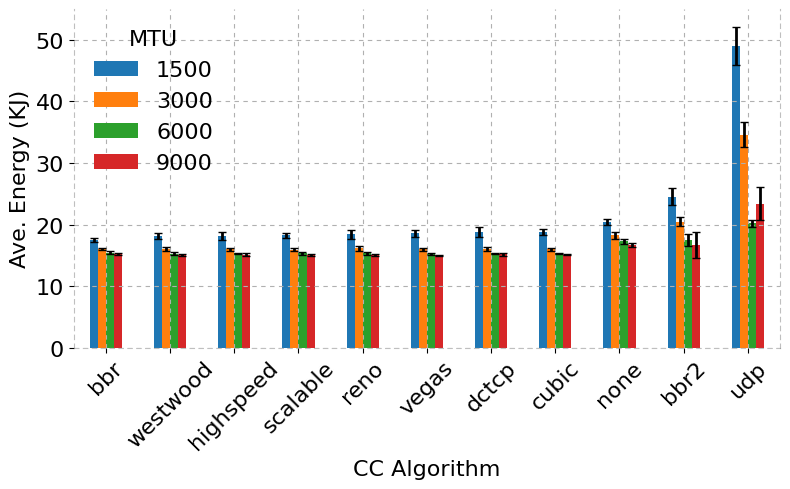

In [8]:
# plt.figure(figsize=FIG_SIZE)
exp_df.groupby(['cc', 'mtu'])['energy_kJ'].mean().unstack().sort_values([1500]).plot.bar(
    yerr=exp_df.groupby(['cc', 'mtu'])['energy_kJ'].std().unstack(), 
    error_kw=dict(lw=2, capsize=3, capthick=1, ecolor='black')
    )

plt.xlabel('CC Algorithm', fontsize=FONT_SIZE)
plt.ylabel('Ave. Energy (KJ)', fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.ylim((0, 55))
plt.xticks(rotation = 45)
plt.grid(linestyle=LINE_STYLE)
leg = plt.gca().legend(loc='upper left', frameon=False, 
                 title='MTU', fontsize=FONT_SIZE)
plt.setp(leg.get_title(),fontsize=FONT_SIZE)
plt.gca().spines["right"].set_linestyle(LINE_STYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINE_STYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["top"].set_linestyle(LINE_STYLE)
# plt.gca().spines["top"].set_alpha(0.5)
# plt.gca().spines["top"].set_color('gray')
plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')
plt.tight_layout()

if (SAVE_FIG):
    plt.savefig( out_dir + '/cca_energy.pdf')

plt.show()

# Comparing Energy consumption to Iperf Stats

In [9]:
stats_to_corr = ['total_cpu_util_percent', 'user_cpu_util_percent', 
                 'system_cpu_util_percent', 'time_sec', 'sent_bytes', 'bps', 
                 'rtx_pkts', 'min_rtt', 'mean_rtt', 'max_rtt', 'max_cwnd']
print('==== Correlation between Energy Consumption and Iperf Stats ====')
for stat_to_corr in stats_to_corr:
    print('{:>31}: {:.3f}'.format(stat_to_corr, exp_df['energy_kJ'].corr(exp_df[stat_to_corr])))

==== Correlation between Energy Consumption and Iperf Stats ====
         total_cpu_util_percent: 0.722
          user_cpu_util_percent: 0.864
        system_cpu_util_percent: 0.557
                       time_sec: 0.926
                     sent_bytes: -0.075
                            bps: -0.871
                       rtx_pkts: 0.019
                        min_rtt: -0.503
                       mean_rtt: -0.499
                        max_rtt: -0.495
                       max_cwnd: 0.068


In [10]:
mtus = exp_df['mtu'].unique()
n_colors = len(mtus)
bins = [mtus[0]-(mtus[1]-mtus[0])/2]
for i in range(len(mtus)):
    bins.append(2*mtus[i]-bins[-1]) 
cmap = matplotlib.colormaps['tab20b'].resampled(n_colors)
norm = matplotlib.colors.BoundaryNorm(boundaries=bins, ncolors=n_colors)

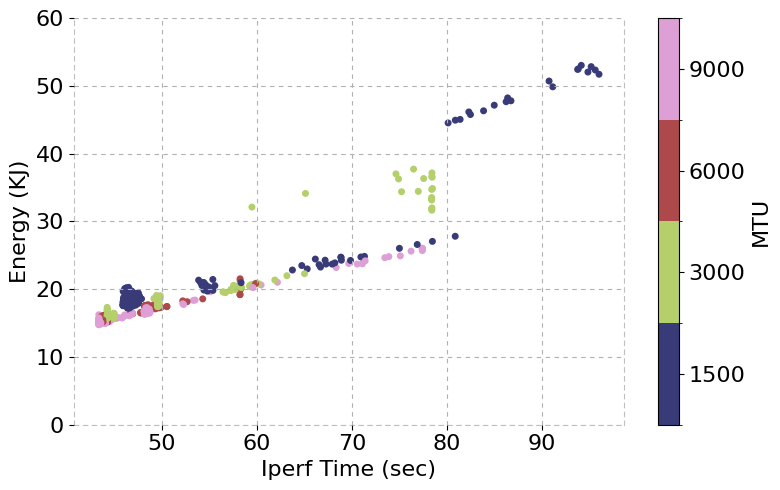

In [11]:
exp_df.plot.scatter(y='energy_kJ', x='time_sec', c='mtu', colormap=cmap, norm=norm, s=16)

cbar = plt.get_cmap()
cbar_ax = plt.gcf().get_axes()[-1]
cbar_ax.get_yaxis().set_ticks(mtus)
cbar_ax.set_yticklabels(labels=mtus, fontsize=FONT_SIZE)
cbar_ax.set_ylabel('MTU',size=FONT_SIZE)

plt.xlabel('Iperf Time (sec)', fontsize=FONT_SIZE)
plt.ylabel('Energy (KJ)', fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.ylim((0, 60))
plt.grid(linestyle=LINE_STYLE)
plt.gca().spines["right"].set_linestyle(LINE_STYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINE_STYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["top"].set_linestyle(LINE_STYLE)
# plt.gca().spines["top"].set_alpha(0.5)
# plt.gca().spines["top"].set_color('gray')
plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')
plt.tight_layout()

if (SAVE_FIG):
    plt.savefig( out_dir + '/energy_vs_time_per_mtu.pdf')

plt.show()

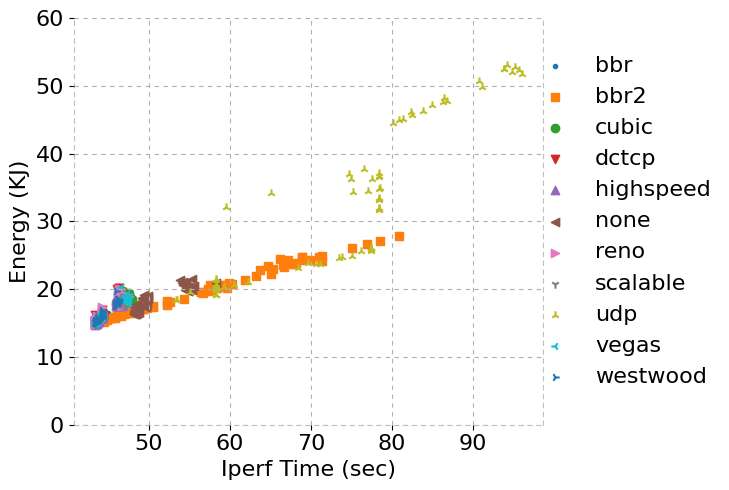

In [12]:
plt.figure(figsize=FIG_SIZE)
marker = 0
for cca, cc_df in exp_df.groupby('cc'):
    plt.scatter(cc_df['time_sec'], cc_df['energy_kJ'], label=cca, 
                marker=list(Line2D.markers.keys())[marker])
    marker += 1

plt.xlabel('Iperf Time (sec)', fontsize=FONT_SIZE)
plt.ylabel('Energy (KJ)', fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.ylim((0, 60))
plt.grid(linestyle=LINE_STYLE)
plt.legend(loc='center right', frameon=False, fontsize=FONT_SIZE, 
           bbox_to_anchor=(1.4, 0.5))

plt.gca().spines["right"].set_linestyle(LINE_STYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINE_STYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["top"].set_linestyle(LINE_STYLE)
# plt.gca().spines["top"].set_alpha(0.5)
# plt.gca().spines["top"].set_color('gray')
plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')
plt.tight_layout()

if (SAVE_FIG):
    plt.savefig( out_dir + '/energy_vs_time_per_cca.pdf')

plt.show()

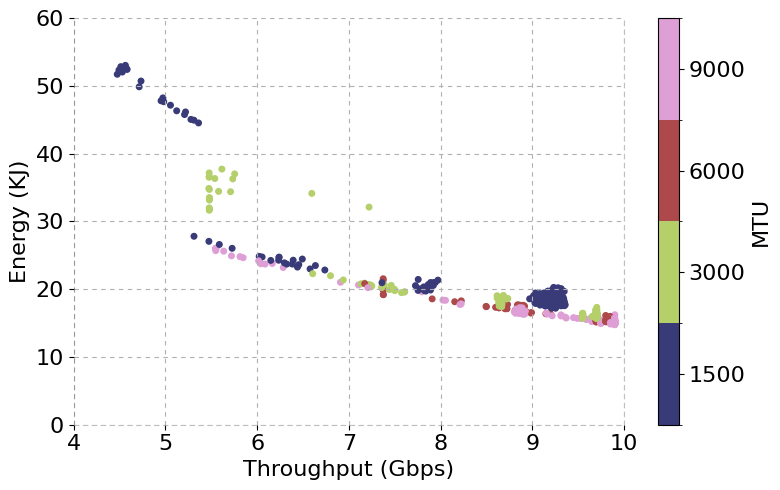

In [13]:
exp_df['gbps'] = exp_df['bps'] * 1e-9
exp_df.plot.scatter(y='energy_kJ', x='gbps', c='mtu', colormap=cmap, norm=norm, s=16)

cbar = plt.get_cmap()
cbar_ax = plt.gcf().get_axes()[-1]
cbar_ax.get_yaxis().set_ticks(mtus)
cbar_ax.set_yticklabels(labels=mtus, fontsize=FONT_SIZE)
cbar_ax.set_ylabel('MTU',size=FONT_SIZE)

plt.xlabel('Throughput (Gbps)', fontsize=FONT_SIZE)
plt.ylabel('Energy (KJ)', fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.ylim((0, 60))
plt.xlim((4, 10))
plt.grid(linestyle=LINE_STYLE)
plt.gca().spines["right"].set_linestyle(LINE_STYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINE_STYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["top"].set_linestyle(LINE_STYLE)
# plt.gca().spines["top"].set_alpha(0.5)
# plt.gca().spines["top"].set_color('gray')
plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')
plt.tight_layout()

if (SAVE_FIG):
    plt.savefig( out_dir + '/energy_vs_bps_per_mtu.pdf')

plt.show()

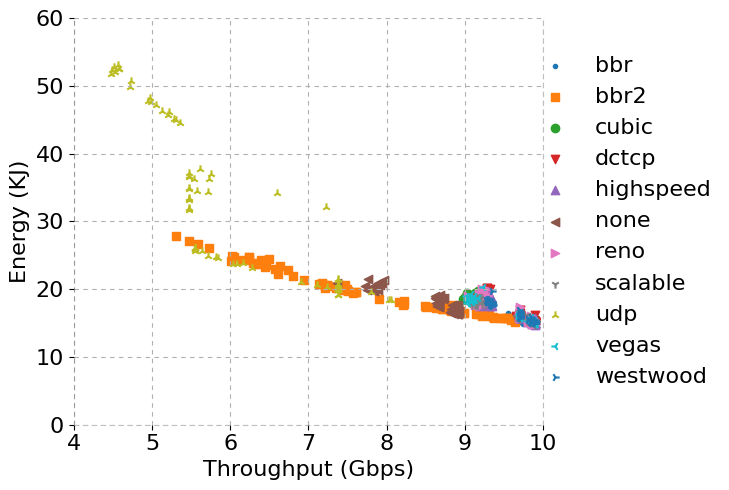

In [14]:
plt.figure(figsize=FIG_SIZE)
marker = 0
for cca, cc_df in exp_df.groupby('cc'):
    plt.scatter(cc_df['gbps'], cc_df['energy_kJ'], label=cca, 
                marker=list(Line2D.markers.keys())[marker])
    marker += 1

plt.xlabel('Throughput (Gbps)', fontsize=FONT_SIZE)
plt.ylabel('Energy (KJ)', fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.ylim((0, 60))
plt.xlim((4, 10))
plt.grid(linestyle=LINE_STYLE)
plt.legend(loc='center right', frameon=False, fontsize=FONT_SIZE, 
           bbox_to_anchor=(1.4, 0.5))

plt.gca().spines["right"].set_linestyle(LINE_STYLE)
plt.gca().spines["right"].set_alpha(0.5)
plt.gca().spines["right"].set_color('gray')
plt.gca().spines["left"].set_linestyle(LINE_STYLE)
plt.gca().spines["left"].set_alpha(0.5)
plt.gca().spines["left"].set_color('gray')
plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["top"].set_linestyle(LINE_STYLE)
# plt.gca().spines["top"].set_alpha(0.5)
# plt.gca().spines["top"].set_color('gray')
plt.gca().spines["bottom"].set_linestyle(LINE_STYLE)
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["bottom"].set_color('gray')
plt.tight_layout()

if (SAVE_FIG):
    plt.savefig( out_dir + '/energy_vs_bps_per_cca.pdf')

plt.show()

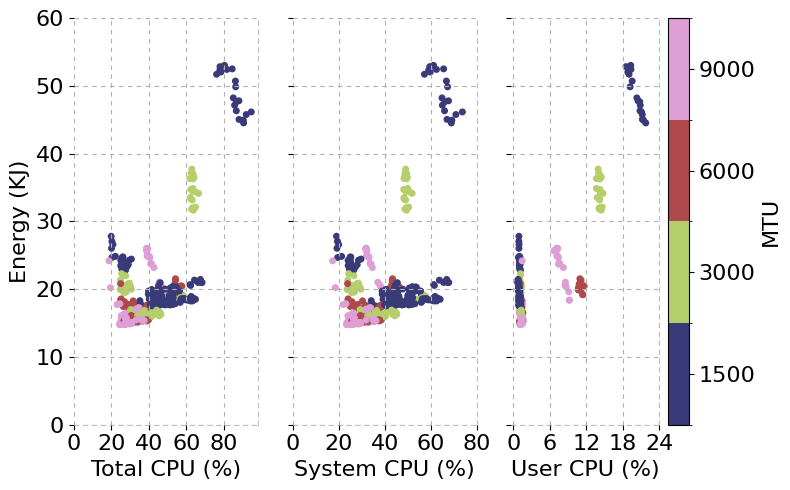

In [15]:
fig, ax = plt.subplots(1, 3)

exp_df.plot.scatter(y='energy_kJ', x='total_cpu_util_percent', c='mtu', 
                    colormap=cmap, norm=norm, s=16, ax=ax[0], colorbar=False)

ax[0].set_ylabel('Energy (KJ)', fontsize=FONT_SIZE)
ax[0].set_xlabel('Total CPU (%)', fontsize=FONT_SIZE)
ax[0].tick_params(axis='x', labelsize=FONT_SIZE)
ax[0].tick_params(axis='y', labelsize=FONT_SIZE)
ax[0].xaxis.set_ticks(np.arange(0, 81, 20))
ax[0].set_ylim((0, 60))
ax[0].grid(linestyle=LINE_STYLE)
ax[0].spines["right"].set_linestyle(LINE_STYLE)
ax[0].spines["right"].set_alpha(0.5)
ax[0].spines["right"].set_color('gray')
ax[0].spines["left"].set_visible(False)
# ax[0].spines["left"].set_linestyle(LINE_STYLE)
# ax[0].spines["left"].set_alpha(0.5)
# ax[0].spines["left"].set_color('gray')
ax[0].spines["top"].set_visible(False)
ax[0].spines["bottom"].set_linestyle(LINE_STYLE)
ax[0].spines["bottom"].set_alpha(0.5)
ax[0].spines["bottom"].set_color('gray')

exp_df.plot.scatter(y='energy_kJ', x='system_cpu_util_percent', c='mtu', 
                    colormap=cmap, norm=norm, s=16, ax=ax[1], colorbar=False)

ax[1].set_xlabel('System CPU (%)', fontsize=FONT_SIZE)
ax[1].set_ylabel('')
ax[1].set_yticklabels([])
ax[1].tick_params(axis='x', labelsize=FONT_SIZE)
ax[1].xaxis.set_ticks(np.arange(0, 81, 20))
ax[1].set_ylim((0, 60))
ax[1].grid(linestyle=LINE_STYLE)
ax[1].spines["right"].set_linestyle(LINE_STYLE)
ax[1].spines["right"].set_alpha(0.5)
ax[1].spines["right"].set_color('gray')
ax[1].spines["left"].set_visible(False)
# ax[1].spines["left"].set_linestyle(LINE_STYLE)
# ax[1].spines["left"].set_alpha(0.5)
# ax[1].spines["left"].set_color('gray')
ax[1].spines["top"].set_visible(False)
ax[1].spines["bottom"].set_linestyle(LINE_STYLE)
ax[1].spines["bottom"].set_alpha(0.5)
ax[1].spines["bottom"].set_color('gray')

exp_df.plot.scatter(y='energy_kJ', x='user_cpu_util_percent', c='mtu', 
                    colormap=cmap, norm=norm, s=16, ax=ax[2])

ax[2].set_xlabel('User CPU (%)', fontsize=FONT_SIZE)
ax[2].set_ylabel('')
ax[2].set_yticklabels([])

cbar = plt.get_cmap()
cbar_ax = plt.gcf().get_axes()[-1]
cbar_ax.get_yaxis().set_ticks(mtus)
cbar_ax.set_yticklabels(labels=mtus, fontsize=FONT_SIZE)
cbar_ax.set_ylabel('MTU',size=FONT_SIZE)

ax[2].tick_params(axis='x', labelsize=FONT_SIZE)
ax[2].xaxis.set_ticks(np.arange(0, 25, 6))
ax[2].set_ylim((0, 60))
ax[2].grid(linestyle=LINE_STYLE)
ax[2].spines["right"].set_linestyle(LINE_STYLE)
ax[2].spines["right"].set_alpha(0.5)
ax[2].spines["right"].set_color('gray')
ax[2].spines["left"].set_visible(False)
# ax[2].spines["left"].set_linestyle(LINE_STYLE)
# ax[2].spines["left"].set_alpha(0.5)
# ax[2].spines["left"].set_color('gray')
ax[2].spines["top"].set_visible(False)
ax[2].spines["bottom"].set_linestyle(LINE_STYLE)
ax[2].spines["bottom"].set_alpha(0.5)
ax[2].spines["bottom"].set_color('gray')

plt.tight_layout()

if (SAVE_FIG):
    plt.savefig( out_dir + '/energy_vs_cpu_per_mtu.pdf')

plt.show()


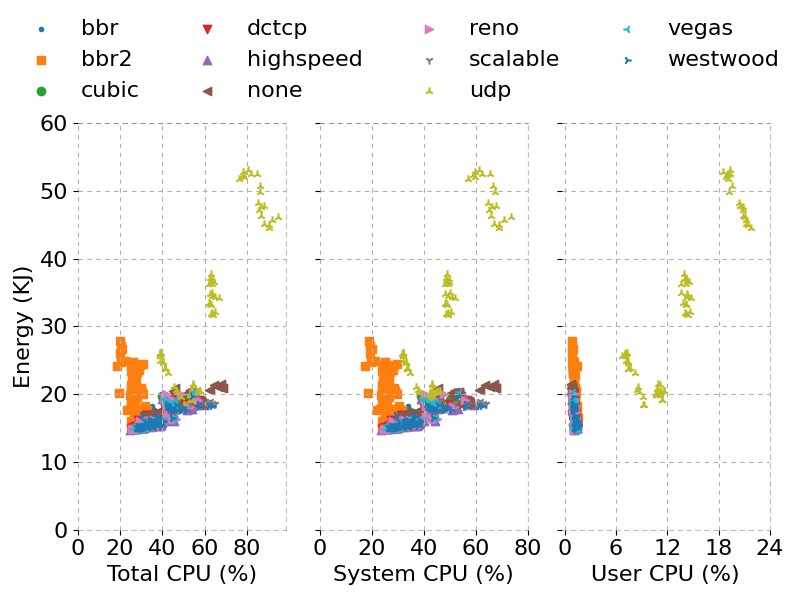

In [16]:
fig, ax = plt.subplots(1, 3, figsize=FIG_SIZE)

marker = 0
for cca, cc_df in exp_df.groupby('cc'):
    ax[0].scatter(cc_df['total_cpu_util_percent'], cc_df['energy_kJ'],
                marker=list(Line2D.markers.keys())[marker])
    marker += 1

ax[0].set_ylabel('Energy (KJ)', fontsize=FONT_SIZE)
ax[0].set_xlabel('Total CPU (%)', fontsize=FONT_SIZE)
ax[0].tick_params(axis='x', labelsize=FONT_SIZE)
ax[0].tick_params(axis='y', labelsize=FONT_SIZE)
ax[0].xaxis.set_ticks(np.arange(0, 81, 20))
ax[0].set_ylim((0, 60))
ax[0].grid(linestyle=LINE_STYLE)
ax[0].spines["right"].set_linestyle(LINE_STYLE)
ax[0].spines["right"].set_alpha(0.5)
ax[0].spines["right"].set_color('gray')
ax[0].spines["left"].set_visible(False)
# ax[0].spines["left"].set_linestyle(LINE_STYLE)
# ax[0].spines["left"].set_alpha(0.5)
# ax[0].spines["left"].set_color('gray')
# ax[0].spines["top"].set_visible(False)
ax[0].spines["top"].set_linestyle(LINE_STYLE)
ax[0].spines["top"].set_alpha(0.5)
ax[0].spines["top"].set_color('gray')
ax[0].spines["bottom"].set_linestyle(LINE_STYLE)
ax[0].spines["bottom"].set_alpha(0.5)
ax[0].spines["bottom"].set_color('gray')

marker = 0
for cca, cc_df in exp_df.groupby('cc'):
    ax[1].scatter(cc_df['system_cpu_util_percent'], cc_df['energy_kJ'], 
                marker=list(Line2D.markers.keys())[marker])
    marker += 1

ax[1].set_xlabel('System CPU (%)', fontsize=FONT_SIZE)
ax[1].set_ylabel('')
ax[1].set_yticklabels([])
ax[1].tick_params(axis='x', labelsize=FONT_SIZE)
ax[1].xaxis.set_ticks(np.arange(0, 81, 20))
ax[1].set_ylim((0, 60))
ax[1].grid(linestyle=LINE_STYLE)
ax[1].spines["right"].set_linestyle(LINE_STYLE)
ax[1].spines["right"].set_alpha(0.5)
ax[1].spines["right"].set_color('gray')
ax[1].spines["left"].set_visible(False)
# ax[1].spines["left"].set_linestyle(LINE_STYLE)
# ax[1].spines["left"].set_alpha(0.5)
# ax[1].spines["left"].set_color('gray')
# ax[1].spines["top"].set_visible(False)
ax[1].spines["top"].set_linestyle(LINE_STYLE)
ax[1].spines["top"].set_alpha(0.5)
ax[1].spines["top"].set_color('gray')
ax[1].spines["bottom"].set_linestyle(LINE_STYLE)
ax[1].spines["bottom"].set_alpha(0.5)
ax[1].spines["bottom"].set_color('gray')

marker = 0
for cca, cc_df in exp_df.groupby('cc'):
    ax[2].scatter(cc_df['user_cpu_util_percent'], cc_df['energy_kJ'], label=cca, 
                marker=list(Line2D.markers.keys())[marker])
    marker += 1

ax[2].set_xlabel('User CPU (%)', fontsize=FONT_SIZE)
ax[2].set_ylabel('')
ax[2].set_yticklabels([])
ax[2].tick_params(axis='x', labelsize=FONT_SIZE)
ax[2].xaxis.set_ticks(np.arange(0, 25, 6))
ax[2].set_ylim((0, 60))
ax[2].grid(linestyle=LINE_STYLE)
ax[2].spines["right"].set_linestyle(LINE_STYLE)
ax[2].spines["right"].set_alpha(0.5)
ax[2].spines["right"].set_color('gray')
ax[2].spines["left"].set_visible(False)
# ax[2].spines["left"].set_linestyle(LINE_STYLE)
# ax[2].spines["left"].set_alpha(0.5)
# ax[2].spines["left"].set_color('gray')
# ax[2].spines["top"].set_visible(False)
ax[2].spines["top"].set_linestyle(LINE_STYLE)
ax[2].spines["top"].set_alpha(0.5)
ax[2].spines["top"].set_color('gray')
ax[2].spines["bottom"].set_linestyle(LINE_STYLE)
ax[2].spines["bottom"].set_alpha(0.5)
ax[2].spines["bottom"].set_color('gray')


lgd = fig.legend(loc='center', frameon=False, fontsize=FONT_SIZE, 
                 bbox_to_anchor=(0.5, 1.08), ncol=4)

plt.tight_layout()

if (SAVE_FIG):
    plt.savefig( out_dir + '/energy_vs_cpu_per_cca.pdf', 
                bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()


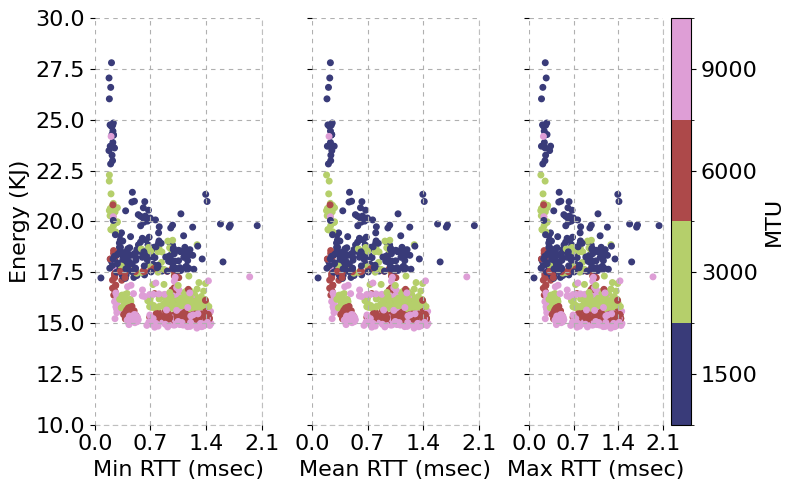

In [17]:
fig, ax = plt.subplots(1, 3)

exp_df.plot.scatter(y='energy_kJ', x='min_rtt', c='mtu', 
                    colormap=cmap, norm=norm, s=16, ax=ax[0], colorbar=False)

ax[0].set_ylabel('Energy (KJ)', fontsize=FONT_SIZE)
ax[0].set_xlabel('Min RTT (msec)', fontsize=FONT_SIZE)
ax[0].tick_params(axis='x', labelsize=FONT_SIZE)
ax[0].tick_params(axis='y', labelsize=FONT_SIZE)
ax[0].xaxis.set_ticks(np.arange(0, 2.2, 0.7))
ax[0].set_xlim((0, 2.1))
ax[0].set_ylim((10, 30))
ax[0].grid(linestyle=LINE_STYLE)
ax[0].spines["right"].set_linestyle(LINE_STYLE)
ax[0].spines["right"].set_alpha(0.5)
ax[0].spines["right"].set_color('gray')
ax[0].spines["left"].set_visible(False)
# ax[0].spines["left"].set_linestyle(LINE_STYLE)
# ax[0].spines["left"].set_alpha(0.5)
# ax[0].spines["left"].set_color('gray')
ax[0].spines["top"].set_visible(False)
ax[0].spines["bottom"].set_linestyle(LINE_STYLE)
ax[0].spines["bottom"].set_alpha(0.5)
ax[0].spines["bottom"].set_color('gray')

exp_df.plot.scatter(y='energy_kJ', x='mean_rtt', c='mtu', 
                    colormap=cmap, norm=norm, s=16, ax=ax[1], colorbar=False)

ax[1].set_xlabel('Mean RTT (msec)', fontsize=FONT_SIZE)
ax[1].set_ylabel('')
ax[1].set_yticklabels([])
ax[1].tick_params(axis='x', labelsize=FONT_SIZE)
ax[1].xaxis.set_ticks(np.arange(0, 2.2, 0.7))
ax[1].set_xlim((0, 2.1))
ax[1].set_ylim((10, 30))
ax[1].grid(linestyle=LINE_STYLE)
ax[1].spines["right"].set_linestyle(LINE_STYLE)
ax[1].spines["right"].set_alpha(0.5)
ax[1].spines["right"].set_color('gray')
ax[1].spines["left"].set_visible(False)
# ax[1].spines["left"].set_linestyle(LINE_STYLE)
# ax[1].spines["left"].set_alpha(0.5)
# ax[1].spines["left"].set_color('gray')
ax[1].spines["top"].set_visible(False)
ax[1].spines["bottom"].set_linestyle(LINE_STYLE)
ax[1].spines["bottom"].set_alpha(0.5)
ax[1].spines["bottom"].set_color('gray')

exp_df.plot.scatter(y='energy_kJ', x='max_rtt', c='mtu', 
                    colormap=cmap, norm=norm, s=16, ax=ax[2])

ax[2].set_xlabel('Max RTT (msec)', fontsize=FONT_SIZE)
ax[2].set_ylabel('')
ax[2].set_yticklabels([])

cbar = plt.get_cmap()
cbar_ax = plt.gcf().get_axes()[-1]
cbar_ax.get_yaxis().set_ticks(mtus)
cbar_ax.set_yticklabels(labels=mtus, fontsize=FONT_SIZE)
cbar_ax.set_ylabel('MTU',size=FONT_SIZE)

ax[2].tick_params(axis='x', labelsize=FONT_SIZE)
ax[2].xaxis.set_ticks(np.arange(0, 2.2, 0.7))
ax[2].set_xlim((0, 2.1))
ax[2].set_ylim((10, 30))
ax[2].grid(linestyle=LINE_STYLE)
ax[2].spines["right"].set_linestyle(LINE_STYLE)
ax[2].spines["right"].set_alpha(0.5)
ax[2].spines["right"].set_color('gray')
ax[2].spines["left"].set_visible(False)
# ax[2].spines["left"].set_linestyle(LINE_STYLE)
# ax[2].spines["left"].set_alpha(0.5)
# ax[2].spines["left"].set_color('gray')
ax[2].spines["top"].set_visible(False)
ax[2].spines["bottom"].set_linestyle(LINE_STYLE)
ax[2].spines["bottom"].set_alpha(0.5)
ax[2].spines["bottom"].set_color('gray')

plt.tight_layout()

if (SAVE_FIG):
    plt.savefig( out_dir + '/energy_vs_rtt_per_mtu.pdf')

plt.show()


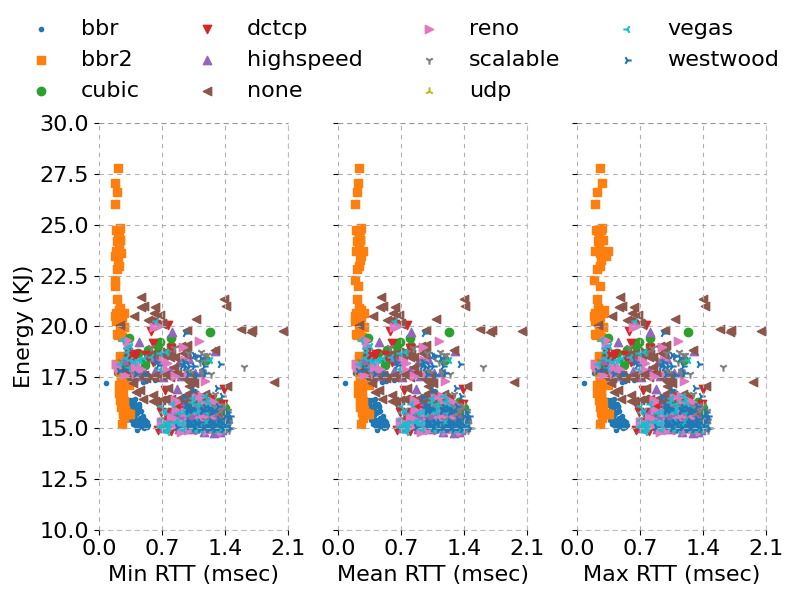

In [18]:
fig, ax = plt.subplots(1, 3, figsize=FIG_SIZE)

marker = 0
for cca, cc_df in exp_df.groupby('cc'):
    ax[0].scatter(cc_df['min_rtt'], cc_df['energy_kJ'],
                marker=list(Line2D.markers.keys())[marker])
    marker += 1

ax[0].set_ylabel('Energy (KJ)', fontsize=FONT_SIZE)
ax[0].set_xlabel('Min RTT (msec)', fontsize=FONT_SIZE)
ax[0].tick_params(axis='x', labelsize=FONT_SIZE)
ax[0].tick_params(axis='y', labelsize=FONT_SIZE)
ax[0].xaxis.set_ticks(np.arange(0, 2.2, 0.7))
ax[0].set_xlim((0, 2.1))
ax[0].set_ylim((10, 30))
ax[0].grid(linestyle=LINE_STYLE)
ax[0].spines["right"].set_linestyle(LINE_STYLE)
ax[0].spines["right"].set_alpha(0.5)
ax[0].spines["right"].set_color('gray')
ax[0].spines["left"].set_visible(False)
# ax[0].spines["left"].set_linestyle(LINE_STYLE)
# ax[0].spines["left"].set_alpha(0.5)
# ax[0].spines["left"].set_color('gray')
# ax[0].spines["top"].set_visible(False)
ax[0].spines["top"].set_linestyle(LINE_STYLE)
ax[0].spines["top"].set_alpha(0.5)
ax[0].spines["top"].set_color('gray')
ax[0].spines["bottom"].set_linestyle(LINE_STYLE)
ax[0].spines["bottom"].set_alpha(0.5)
ax[0].spines["bottom"].set_color('gray')

marker = 0
for cca, cc_df in exp_df.groupby('cc'):
    ax[1].scatter(cc_df['mean_rtt'], cc_df['energy_kJ'], 
                marker=list(Line2D.markers.keys())[marker])
    marker += 1

ax[1].set_xlabel('Mean RTT (msec)', fontsize=FONT_SIZE)
ax[1].set_ylabel('')
ax[1].set_yticklabels([])
ax[1].tick_params(axis='x', labelsize=FONT_SIZE)
ax[1].xaxis.set_ticks(np.arange(0, 2.2, 0.7))
ax[1].set_xlim((0, 2.1))
ax[1].set_ylim((10, 30))
ax[1].grid(linestyle=LINE_STYLE)
ax[1].spines["right"].set_linestyle(LINE_STYLE)
ax[1].spines["right"].set_alpha(0.5)
ax[1].spines["right"].set_color('gray')
ax[1].spines["left"].set_visible(False)
# ax[1].spines["left"].set_linestyle(LINE_STYLE)
# ax[1].spines["left"].set_alpha(0.5)
# ax[1].spines["left"].set_color('gray')
# ax[1].spines["top"].set_visible(False)
ax[1].spines["top"].set_linestyle(LINE_STYLE)
ax[1].spines["top"].set_alpha(0.5)
ax[1].spines["top"].set_color('gray')
ax[1].spines["bottom"].set_linestyle(LINE_STYLE)
ax[1].spines["bottom"].set_alpha(0.5)
ax[1].spines["bottom"].set_color('gray')

marker = 0
for cca, cc_df in exp_df.groupby('cc'):
    ax[2].scatter(cc_df['max_rtt'], cc_df['energy_kJ'], label=cca, 
                marker=list(Line2D.markers.keys())[marker])
    marker += 1

ax[2].set_xlabel('Max RTT (msec)', fontsize=FONT_SIZE)
ax[2].set_ylabel('')
ax[2].set_yticklabels([])
ax[2].tick_params(axis='x', labelsize=FONT_SIZE)
ax[2].xaxis.set_ticks(np.arange(0, 2.2, 0.7))
ax[2].set_xlim((0, 2.1))
ax[2].set_ylim((10, 30))
ax[2].grid(linestyle=LINE_STYLE)
ax[2].spines["right"].set_linestyle(LINE_STYLE)
ax[2].spines["right"].set_alpha(0.5)
ax[2].spines["right"].set_color('gray')
ax[2].spines["left"].set_visible(False)
# ax[2].spines["left"].set_linestyle(LINE_STYLE)
# ax[2].spines["left"].set_alpha(0.5)
# ax[2].spines["left"].set_color('gray')
# ax[2].spines["top"].set_visible(False)
ax[2].spines["top"].set_linestyle(LINE_STYLE)
ax[2].spines["top"].set_alpha(0.5)
ax[2].spines["top"].set_color('gray')
ax[2].spines["bottom"].set_linestyle(LINE_STYLE)
ax[2].spines["bottom"].set_alpha(0.5)
ax[2].spines["bottom"].set_color('gray')


lgd = fig.legend(loc='center', frameon=False, fontsize=FONT_SIZE, 
                 bbox_to_anchor=(0.5, 1.08), ncol=4)

plt.tight_layout()

if (SAVE_FIG):
    plt.savefig(out_dir + '/energy_vs_rtt_per_cca.pdf', 
                bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()